<a href="https://colab.research.google.com/github/gitudaniel/fastai-course-notes/blob/main/Multi_label_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

- Multi-label classification refers to the problem of identifying the categories of objects in an image where there may be more than one type of object in an image.

- There may be more than one kind of object, or there may be no objects at all in the classes that you're looking for.

- In practice, it is probably more common to have some images with zero matches or more than one match. We should therefore expect multi-label classifiers to be more widely applicable than single label classifiers.

- First, we'll see how a multi-label dataset looks like, then we'll explain how to get it ready for our model.

- We'll then see that the architecture does not change from the last chapter (pet breeds classification), only the loss function does.

## The data

- We're going to use the *Pascal dataset*, which can have more than one classified object per image.

In [ ]:
!pip install --upgrade fastai

Requirement already up-to-date: fastai in /usr/local/lib/python3.7/dist-packages (2.3.1)


In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.PASCAL_2007)

- This dataset comes with a CSV file telling us what labels to use for each image

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


- We can see that the list of categories in each image is shown as a space delimited string.

## Pandas and DataFrames

- *Pandas* is a Python library that is used to manipulate and analyse tabular and timeseries data.

- The main class is `DataFrame` which represents a table of rows and columns.

- You can get a DataFrame from a CSV file, a database table, python dictionaries etc.

- In Jupyter a DataFrame is formatted as a table

- The `iloc` (integer location) property lets you access rows and columns of a DataFrame as if it is a matrix

In [ ]:
# everything from the first column
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [ ]:
# everything from the first row
df.iloc[0,:]

# trailing ':'s are always optional in numpy, PyTorch, pandas etc
# so this is equivalent
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

- You can grab a column by name by indexing into a DataFrame directly:

In [ ]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

- You can create new columns and do calculations using columns:

In [ ]:
tmp_df = pd.DataFrame({'a': [1,2], 'b': [3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [ ]:
tmp_df['c'] = tmp_df['a'] + tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


- Pandas is a fast and flexible library, unfortunately, its API can be rather confusing and surprising and takes a while to get familiar with it.

- The book *'Python for Data Analysis'* by Wes McKinney (creator of Pandas) does a great job of covering libraries like Pandas, matplotlib and numpy

## Constructing a data block

- To convert from a `DataFrame` object to a `DataLoaders` object, we use the data block API for creating a `DataLoaders` object.

- As we have seen, PyTorch and fastai have two main classes for representing and accessing a training set or validation set:
  - `Dataset` :: a collection which returns a tuple of your independent and dependent variables for a single item.
  - `DataLoader` :: an iterator which provides a stream of mini batches, where each mini batch consists of a batch of independent variables and a batch of dependent variables.

In [ ]:
# example dataset
"""A dataset is anything you can index into and take the length of it.
When you index into a dataset, you expect to get back a tuple with the independent and dependent variable.
"""
a = list(enumerate(string.ascii_lowercase))
a[0], len(a)

((0, 'a'), 26)

In [ ]:
# example dataloader
# a mini-batch is made up of a mini-batch of the independent variable
# and a mini-batch of the dependent variable
dl_a = DataLoader(a, batch_size=8, shuffle=True)
b = first(dl_a)  # grab the first value from the iterator
b

(tensor([20, 12,  2,  7, 18,  5, 23, 24]),
 ('u', 'm', 'c', 'h', 's', 'f', 'x', 'y'))

In [ ]:
list(zip(b[0], b[1]))

[(tensor(20), 'u'),
 (tensor(12), 'm'),
 (tensor(2), 'c'),
 (tensor(7), 'h'),
 (tensor(18), 's'),
 (tensor(5), 'f'),
 (tensor(23), 'x'),
 (tensor(24), 'y')]

In [ ]:
"""*b means insert into this parameter list each element of b"""
list(zip(*b))

[(tensor(20), 'u'),
 (tensor(12), 'm'),
 (tensor(2), 'c'),
 (tensor(7), 'h'),
 (tensor(18), 's'),
 (tensor(5), 'f'),
 (tensor(23), 'x'),
 (tensor(24), 'y')]

- On top of these, fastai provides two classes for bringing your training and validation sets together:
  - `Datasets` :: an object containing a training and validation `Dataset`
  - `DataLoaders` :: an object containing a training `DataLoader` and a validation `DataLoader`.

- Normally, you don't start with an enumeration as we've seen above with an independent and dependent variable.

- Normally, you start with a filename. You then transform your filename into an image by opening it, and a label by looking at the filename and grabbing something from it.

- This is what `Datasets` does.

In [ ]:
a = list(string.ascii_lowercase)
a[0], len(a)  # this is still a dataset -> we can index into it and get the length

('a', 26)

In [ ]:
dss = Datasets(a)
dss[0]

('a',)

- If we pass our list to Datasets we get back a tuple with just one item.

- In practice, what we really want to do is to take this tuple and do something to compute the independent and dependent variable.

In [ ]:
def f1(o): return o+'a'  # independent variable has "a" at the end
def f2(o): return o+'b'  # dependent variable has "b" at the end

- We can now call Datasets, passing in a and we can pass in a list of transformations to do.

In [ ]:
dss = Datasets(a, [[f1]])
dss[0]

('aa',)

- If you pass multiple functions, it's going to do multiple things.

In [ ]:
dss = Datasets(a, [[f1,f2]])
dss[0]

('aab',)

- The transformations are a list of lists because you can also pass in a list containing `f1` and a list containing `f2`.

- What this does is it takes each element of `a`, passes it through the first list of functions, then start again and pass it throught the second list of functions.

In [ ]:
dss = Datasets(a, [[f1], [f2]])
dss[0]

('aa', 'ab')

- This is the main way we build up independent and dependent variables in fastai.

- We start with something like a filename and we pass it through two lists of functions.

- One of them generally opens up the image and the other parses the filename to give you an independent and dependent variable.

- You can then create the `DataLoaders` from the `Datasets` by passing  in the datasets and the batch_size

In [ ]:
dls = DataLoaders.from_dsets(dss, batch_size=4)
first(dls.train)

(('aa', 'wa', 'ka', 'xa'), ('ab', 'wb', 'kb', 'xb'))

- When we create a `DataBlock`, we build up gradually, step-by-step, and use the notebook to check our data along the way.

- This is a great way to make sure that you maintain momentum as you are coding and its easy to debug because if there are any problems, it's the code you just typed.

In [ ]:
# data block with no parameters
dblock = DataBlock()

- We can create a `Datasets` object from this. The only thing needed is a source, in this case, our dataframe:

In [ ]:
dsets = dblock.datasets(df)

- This contains a `train` and a `valid` dataset, which we can index into:

In [ ]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [ ]:
x, y = dsets.train[0]
x, y

(fname       002896.jpg
 labels            bird
 is_valid          True
 Name: 1451, dtype: object, fname       002896.jpg
 labels            bird
 is_valid          True
 Name: 1451, dtype: object)

- This simply returns a row of the dataframe twice.

- This is because by default, the datablock assumes we have two things: input and target.

- We are going to need to grab the appropriate fields from the DataFrame by passing `get_x` and `get_y` functions:

In [ ]:
x['fname']

'002896.jpg'

In [ ]:
x['labels']

'bird'

In [ ]:
dblock = DataBlock(get_x=lambda r: r['fname'], get_y=lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('007336.jpg', 'person')

- Python's *lambda* keyword is just a shortcut for defining and then referring to a function.

- The above is identical to the following more verbose approach:

In [ ]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']

dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('007101.jpg', 'train')

- We don't get the same result every time we create a new dataset because the random split is done differently each time.

- Lambda functions are great for quickly iterating, however, they are not compatible with serialization (saving).

- Use the more verbose approach if you want to export your `Learner` after training (python doesn't like saving things that contain lambdas).

- The independent variable will need to be converted into a complete path, so that we can open it as an image.

- The dependent variable will need to be split on the space character so that it becomes a list.

In [ ]:
Path.BASE_PATH = path

In [ ]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split()

dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('train/004195.jpg'), ['horse', 'person'])

- To actually open the image and do the conversion to tensors, we will need to use a set of transforms; block types will provide us with those.

- The `ImageBlock` will work fine, because we have a path that points to a valid image.

- The `CategoryBlock` is not going to work because it returns a single integer but we need to have multiple labels for each item.

- To solve this we use a `MultiCategoryBlock` which expects to receive a list of strings.

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x224,
 TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1.]))

- As you can see, our list of categories is not encoded in the same way it was for the CategoryBlock.

- In the case of the CategoryBlock, we had a single integer, representing which category was present, based on its location in our vocab.

- In this case, we instead have a list of zeros, with a one in any position where that category is present, e.g. if there is a one in the second and fourth positions, that means that vocab items two and four are present in this image.

- This is known as *one hot encoding*.

- We can't use a list of category indices because each list would be a different length, and PyTorch requires tensors, where everything has to be the same length.

> `One hot encoding`: using a vector of zeros, with a one in each location that is represented in the data, to encode a list of integers.

- Let's check what the categories represent for this example:

In [ ]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#3) ['bottle','chair','tvmonitor']

- With numpy arrays, PyTorch tensors, and fastai's `L` class, you can index directly using a list or vector, which makes a lot of code (such as this example) more clearer and consise.

- We have ignored the column `is_valid` up until now, which means that `DataBlock` has been using a random split by default.

- Our DataFrame there's a column telling us what validation set to use. If the dataset you're given tells you what validation set to use, you should generally use it. That way, you can compare your validation set results to someone elses.

- To explicitly choose the elemens of our validation set, we need to write a function and pass it to `splitter` (or use one of fastai's predefined functions or classes).

- It will take the items (here our whole dataframe) and must return two (or more) integers.

In [ ]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [ ]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [ ]:
valid = df.index[~df['is_valid']]

In [ ]:
valid

Int64Index([   3,    5,    9,   11,   13,   14,   15,   16,   17,   20,
            ...
            4991, 4993, 4996, 4998, 4999, 5000, 5001, 5004, 5009, 5010],
           dtype='int64', length=2501)

In [ ]:
len(valid)

2501

- A `DataLoader` collates items from a `Dataset` into a mini-batch.

- This is a tuple of tensors, where each tensor simply stacks the items from a similar location in the `Dataset` item (image & category in this case).

- We need to ensure that every item is of the same size.

- We do this using `RandomResizedCrop`:

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

- We can now display a sample of our data.

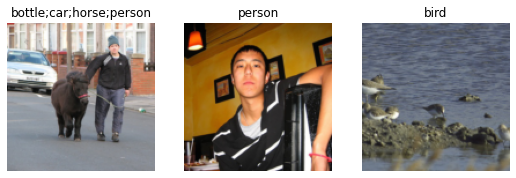

In [ ]:
dls.show_batch(nrows=1, ncols=3)

- If anything goes wrong when you create your `DataLoaders` from your `DataBlock`, or if you want to view exactly what happens with your `DataBlock`, you can use the `summary` method.

In [ ]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /root/.fastai/data/pascal_2007/train/00001

## Binary cross entropy

- We'll now create our `Learner`.

- A `Learner` object contains 4 things:
  - the model
  - a `DataLoaders` object
  - an `Optimizer`
  - the loss function to use

- We already have our `DataLoaders`, and we can leverage fastai's `resnet` models, and we know how to create an `SGD` optimizer.

- Let's focus on ensuring we have a suitable loss function.

- To do this, let's use `cnn_learner` to create a `Learner`, so we can look at its activations:

In [ ]:
learn = cnn_learner(dls, resnet18)

# move model to the GPU
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

- The model in a `Learner` is generally an object of a class inheriting from `nn.Module`.

- By passing it your independent variable as a mini batch, you can call it using parentheses and it will return the activations from the final layer of your model.

- Let's try it out by grabbing a mini batch from our `DataLoader`, and then passing it to the model:

In [ ]:
# get GPU device name
torch.cuda.get_device_name()

'Tesla T4'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
x, y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

- `activs` has this shape because we have a batch size of 64 and we need to calculate the probability of each of 20 categories.

- You should be able to predict what the shape of the activations will look like and confirm it using `activations.shape`.

- If your shape differs from the actual value, understand where you went wrong or confirm whether there is a problem with your code.

In [ ]:
activs[0]

tensor([ 0.9873, -0.1954, -1.9214, -2.5749, -1.9890,  0.3620, -0.1439,  3.3077,
        -1.6808,  2.6641, -1.0578, -0.8381, -2.9310, -1.4611,  2.5631, -0.8486,
        -1.2985, -2.1779, -3.1202,  0.8508], device='cuda:0',
       grad_fn=<SelectBackward>)

> **Note:** Knowing how to manually get a mini batch, pass it into a model and look at the activations and loss is really important for debugging your model. It is also very helpful for learning, so that you can see exactly what's going on.

- Above we see our 20 activations.

-This is not a trained model, it is a pretrained model with a random set of final layer weights so at this point the specific numbers don't mean anything.

- They also aren't scaled between zero and one.

- We can use the `sigmoid` function to scale activations to be between zero and one and calculate the loss based on this with the addition of `log`

In [ ]:
def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return torch.where(targets==1, 1-inputs, inputs).log().mean()

- Because we have a one-hot encoded dependent variable, we can't directly use `nll_loss` or `softmax` (and therefore we can't use `cross_entropy`):
    - **softmax** requires that all predictions sum to one, and tends to push one activation to be much larger than the others (due to the use of `exp`); however, we may well have multiple objects that we're confident appear in an image, so restricting the maximun sum of activations to one is not a good idea. By the same reasoning, we may want the sum to be *less* than one, if we don't think that *any* of the categories appear in an image.

    - **nll_loss** returns the value of just one activation: the single activation corresponding with the single label for an item. This doesn't make sense when we have multiple labels.

- Binary cross entropy is identical to the loss function we used earlier with our MNIST dataset (3's vs 7's) only with the addition of `.log()`.

- Because we can use broadcasting in PyTorch and element-wise arithmetic, when we pass a whole matrix to `torch.where()` (one-hot encoded dependent variable) the operations will be applied to each column separately and every item separately i.e. each activation will be compared to each target for each column.

- This means that our `binary cross entropy` function is going to be just like our MNIST loss function. But rather than just being is this a number 3, it will be able to tell whether it is a dog, cat, person etc.

- We have expanded our MNIST loss function to handle higher dimensional tensors without doing any extra work.

- PyTorch already provides the binary cross entropy function for us.

- `F.binary_cross_entropy` and its module equivalent `nn.BCELoss`, calculate cross entropy on a one-hot encoded target, but do not include the initial `sigmoid`.

- Normally, for one-hot encoded targets you'll want `F.binary_cross_entropy_with_logits` (or `nn.BCEWithLogitLoss`), which do both sigmoid and binary cross entropy in a single function, as in our example above.

- The equivalent for single-label datasets (MNIST or Pets), where the target is encoded as a single integer is `F.nll_loss` or `nn.NLLLoss` for the version without the initial softmax, and `F.cross_entropy` or `nn.CrossEntropyLoss` for the version with initial softmax.

- Since we have a one-hot encoded target, we'll use `BCEWithLogitsLoss`:

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0280, device='cuda:0', grad_fn=<AliasBackward>)

- fastai knows that the `DataLoaders` have multiple category labels, so it will use `nn.BCEWithLogitsLoss` by default. We therefore don't have to specify the loss function (but we can if we want to).

- One change compared to the last chapter is the metric we use: since we are in a multilabel problem, we can't use the accuracy function.

- Accuracy compares our inputs to our targets like so:
    ```python
    def accuracy(inp, targ, axis=-1):
      "Compute accuracy with `targ` when `pred` is bs * n_classes"
      pred = inp.argmax(dim=axis)
      return (pred == targ).float().mean()
    ```

- Accuracy only works for single label datasets like MNIST or Pets.

- It takes the inputs (final layer activations) and it does the `argmax` (finds the index of the largest number in the activations). It then compares whether the prediction is equal to the target and gets the floating point mean.

- The class predicted will therefore be the one with the highest activation.

- `argmax` only makes sense if there's a single maximum thing that we're looking for and in this case we could have more than one prediction on a single image.

- After applying sigmoid to our activations (make them between 0 and 1), we need to decide which ones are 0s and which one are 1s by picking a *threshold*.

- Each value above the threshold is considered a 1, and each value lower than the threshold will be considered a 0:


In [ ]:
def accuracy_multi(inp, targ, threshold=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp > threshold) == targ.bool()).float().mean()

- When we create our learner, we have to pass to the metrics argument a function.

- If we pass `accuracy_multi` directly as a function, it will use the default value for `threshold` which is 0.5.

- We might want to adjust that default and create a new version of `accuracy_multi` that has a different default.

- To help with this, there is a Python function called `partial`.

- It allows us to bind a function with some arguments, or keyword arguments, making a new version of that function that, whenever it is called, always includes those arguments.

In [ ]:
def say_hello(name, say_what='Hello'): return f"{say_what} {name}"
say_hello('Jeremy'), say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy', 'Ahoy! Jeremy')

- We can switch to a French version using `partial`

In [ ]:
f = partial(say_hello, say_what='Bonjour')
f('Jeremy'), f('Sylvain')

('Bonjour Jeremy', 'Bonjour Sylvain')

- We can now train our model.

- Let's try setting the accuracy threshold to 0.2 for our metric:

In [101]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, threshold=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.947806,0.694623,0.240359,00:28
1,0.825072,0.564893,0.284661,00:27
2,0.603640,0.201840,0.810896,00:28
3,0.361842,0.125813,0.939880,00:27


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.131729,0.117391,0.938586,00:28
1,0.115234,0.104194,0.951394,00:28
2,0.096509,0.102367,0.953247,00:28


- Picking a threshold is important.

- If you pick a threshold that's too low, you'll often be failing to select correctly labelled objects.

- We can see this by changing our metric, then calling `validate`, which returns the validation loss and metrics:

In [102]:
learn.metrics = partial(accuracy_multi, threshold=0.1)
learn.validate()

(#2) [0.10236704349517822,0.9331871867179871]

- If you pick a threshold that's too high, you'll often be selecting correctly labelled objects:

In [103]:
learn.metrics = partial(accuracy_multi, threshold=0.99)
learn.validate()

(#2) [0.10236704349517822,0.9449402689933777]

- We can find the best threshold by trying a few levels and seeing what works best.

- This is much faster if we just grab the predictions once:

In [104]:
preds, targs = learn.get_preds()

- We can then call the metric directly.

- Note that by default `get_preds` applies the output activation function (sigmoid in this case) for us.

- We'll need to tell `accuracy_multi` not to apply it:

In [105]:
accuracy_multi(preds, targs, threshold=0.9, sigmoid=False)

TensorMultiCategory(0.9567)

- We can now use this approach to find the best threshold level:

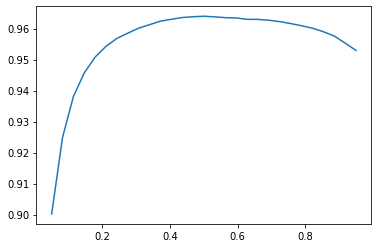

In [108]:
xs = torch.linspace(0.05, 0.95, 29)  # give me 29 numbers between 0.05 & 0.95 inclusive
accs = [accuracy_multi(preds, targs, threshold=i, sigmoid=False) for i in xs]
plt.plot(xs, accs);

- In this case, we're using the validation set to pick a hyperparameter (the threshold), which is the purpose of the validation set.

- Some students have expressed concern that we might be overfitting to the validation set since we're trying lots of values to see which is the best.

- As you can see in the plot, changing the threshold results in a smooth curve, so we're clearly not picking some random outlier.

- This is a good example of where you have to be careful of the difference between theory (don't try lots of hyperparameter values or you might overfit the validation set) versus practice (if the relationship is smooth, then it's fine to do this).